# LLMClassifier Test

Test the LLMClassifier on quark/gluon jet data using Google Gemini API.

This notebook demonstrates:
- Zero-shot jet classification with Gemini 2.5 Flash-Lite
- Thinking budget control (512-24,576 tokens for Flash-Lite)
- Token usage and cost tracking


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from vibe_jet_tagging import LLMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


## Load Data

Load the quark/gluon jet dataset.


In [2]:
# Load data
data_path = Path.cwd().parent / 'data' / 'qg_jets.npz'
data = np.load(data_path)

X = data['X']
y = data['y']

print(f"Loaded {len(X)} jets")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Quark jets: {(y == 1).sum()}")
print(f"Gluon jets: {(y == 0).sum()}")


Loaded 10000 jets
X shape: (10000, 139, 4)
y shape: (10000,)
Quark jets: 5074
Gluon jets: 4926


## Initialize LLMClassifier

Set up the classifier with Google Gemini API.

**Note:** You need a Gemini API key. Get one from [Google AI Studio](https://aistudio.google.com/app/apikey).

Set it as an environment variable:
```bash
export GEMINI_API_KEY="your-key-here"
```

Or add it to your `.env` file in the project root:
```
GEMINI_API_KEY='your-key-here'
```


In [3]:
# Load API key from .env file
from dotenv import load_dotenv
load_dotenv()

# Check if API key is set
if 'GEMINI_API_KEY' not in os.environ:
    print("WARNING: GEMINI_API_KEY not set. Please set it in .env file.")
    print("Create a .env file with: GEMINI_API_KEY='your-key-here'")
else:
    print("✓ Gemini API key found")


✓ Gemini API key found


In [4]:
# Initialize classifier with Gemini API
clf = LLMClassifier(
    model_name="gemini-2.5-flash-lite-preview-09-2025",  # No "google/" prefix
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    thinking_budget=1000,         # Control thinking tokens (512-24,576 for Flash-Lite)
    max_tokens=2000               # Max output tokens (need enough for thinking + output)
)

# Fit (no-op for zero-shot)
clf.fit([], [])

print("Classifier initialized")
print(f"Model: {clf.model_name}")
print(f"Template: {clf.template_name}")
print(f"Format: {clf.format_type}")
print(f"Thinking budget: {clf.thinking_budget}")


Classifier initialized
Model: gemini-2.5-flash-lite-preview-09-2025
Template: simple_list
Format: list
Thinking budget: 1000


## Test Single Jet Prediction


In [5]:
# Test on a single jet
test_jet = X[0]
true_label = y[0]

print(f"True label: {true_label} ({'quark' if true_label == 1 else 'gluon'})")
print(f"\nJet shape: {test_jet.shape}")
print(f"Number of particles (pt > 0): {(test_jet[:, 0] > 0).sum()}")

# Make prediction
prediction = clf.predict([test_jet], verbose=True)[0]
print(f"\nPredicted label: {prediction} ({'quark' if prediction == 1 else 'gluon'})")
print(f"Correct: {prediction == true_label}")


True label: 1.0 (quark)

Jet shape: (139, 4)
Number of particles (pt > 0): 18

🔧 API PARAMETERS
Model: gemini-2.5-flash-lite-preview-09-2025
Max output tokens: 2000
Thinking budget: 1000


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Prompt tokens:     757
Completion tokens: 1
Thinking tokens:   947
├─ Thinking:       947
└─ Output:         1
Total tokens:      1,705

💰 COST
Input cost:        $0.000057
Output cost:       $0.000284
Call cost:         $0.000341

✨ RESPONSE
────────────────────────────────────────────────────────────
Content: 1
────────────────────────────────────────────────────────────


════════════════════════════════════════════════════════════
📈 CUMULATIVE STATISTICS
════════════════════════════════════════════════════════════
Total prompt tokens:     757
Total completion tokens: 1
Total thinking tokens:   947
Total tokens:            1,705

💰 Total estimated cost: $0.000341


In [6]:
clf.preview_prompt(test_jet)

PROMPT PREVIEW
Model: gemini-2.5-flash-lite-preview-09-2025
Template: simple_list
Format: list
Max output tokens: 2000
Thinking budget: 1000

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

Here is the jet data:
Particle 1: pt=0.269 GeV, y=0.357, phi=4.741, pid=22
Particle 2: pt=0.160 GeV, y=-0.256, phi=4.550, pid=22
Particle 3: pt=1.149 GeV, y=-0.062, phi=4.504, pid=-211
Particle 4: pt=4.132 GeV, y=0.174, phi=4.766, pid=-321
Particle 5: pt=1.696 GeV, y=-0.212, phi=4.797, pid=-211
Particle 6: pt=2.194 GeV, y=-0.052, phi=4.576, pid=22
Particle 7: pt=1.619 GeV, y=-0.068, phi=4

## Thinking Budget Control

Test how different thinking budgets affect performance and token usage.

For Gemini 2.5 Flash-Lite:
- **Minimum**: 512 tokens (or 0 to disable)
- **Maximum**: 24,576 tokens
- **Recommended**: 512-2000 for simple tasks, 2000-5000 for complex reasoning


In [7]:
# Test different thinking budgets on a single jet
test_jet = X[0]

budgets = [0, 512, 2000, 5000]
results = []

for budget in budgets:
    print(f"\n{'='*60}")
    print(f"Testing with thinking_budget={budget}")
    print(f"{'='*60}")
    
    clf_test = LLMClassifier(
        model_name="gemini-2.5-flash-lite-preview-09-2025",
        template_name="simple_list",
        format_type="list",
        templates_dir=str(Path.cwd().parent / 'templates'),
        thinking_budget=budget,
        max_tokens=3000
    )
    clf_test.fit([], [])
    
    pred = clf_test.predict([test_jet], verbose=True)[0]
    
    results.append({
        'budget': budget,
        'prediction': pred,
        'thinking_tokens': clf_test.total_thinking_tokens,
        'total_tokens': clf_test.total_prompt_tokens + clf_test.total_completion_tokens + clf_test.total_thinking_tokens,
        'cost': clf_test.total_cost
    })

# Summary
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
for r in results:
    print(f"Budget={r['budget']:5d}: Thinking={r['thinking_tokens']:4d}, Total={r['total_tokens']:5d}, Cost=${r['cost']:.6f}, Pred={r['prediction']}")



Testing with thinking_budget=0

🔧 API PARAMETERS
Model: gemini-2.5-flash-lite-preview-09-2025
Max output tokens: 3000
Thinking budget: 0


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Prompt tokens:     757
Completion tokens: 1
Total tokens:      758

💰 COST
Input cost:        $0.000057
Output cost:       $0.000000
Call cost:         $0.000057

✨ RESPONSE
────────────────────────────────────────────────────────────
Content: 0
────────────────────────────────────────────────────────────


════════════════════════════════════════════════════════════
📈 CUMULATIVE STATISTICS
════════════════════════════════════════════════════════════
Total prompt tokens:     757
Total completion tokens: 1
Total tokens:            758

💰 Total estimated cost: $0.000057
════════════════════════════════════════════════════════════


Testing with thinking_budget=512

🔧 API PARAMETERS
Model: gemini-2.5-flash-lite-previe

## Test on 100 Jets

Run the classifier on 100 jets and compute metrics.


In [8]:
# Select 100 jets
n_test = 100
X_test = X[:n_test]
y_test = y[:n_test]

print(f"Testing on {n_test} jets...")
print(f"True distribution: {(y_test == 1).sum()} quark, {(y_test == 0).sum()} gluon")


Testing on 100 jets...
True distribution: 55 quark, 45 gluon


In [9]:
# Make predictions (this will take a while)
from tqdm.auto import tqdm

predictions = []
for i, jet in enumerate(tqdm(X_test)):
    pred = clf.predict([jet])[0]
    predictions.append(pred)
    
    # Print progress every 10 jets
    if (i + 1) % 10 == 0:
        acc = accuracy_score(y_test[:i+1], predictions)
        print(f"After {i+1} jets: Accuracy = {acc:.3f}")

predictions = np.array(predictions)


/global/cfs/cdirs/m4958/usr/danieltm/Side_Work/FoundationModels/VibeJetTagging/vibe-jet-tagging/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:29<04:12,  2.81s/it]

After 10 jets: Accuracy = 0.200


 20%|██        | 20/100 [00:58<04:04,  3.05s/it]

After 20 jets: Accuracy = 0.450


 30%|███       | 30/100 [01:31<03:40,  3.14s/it]

After 30 jets: Accuracy = 0.500


 40%|████      | 40/100 [02:01<02:43,  2.73s/it]

After 40 jets: Accuracy = 0.475


 50%|█████     | 50/100 [02:33<02:38,  3.17s/it]

After 50 jets: Accuracy = 0.460


 60%|██████    | 60/100 [03:04<02:03,  3.09s/it]

After 60 jets: Accuracy = 0.467


 70%|███████   | 70/100 [03:34<01:36,  3.23s/it]

After 70 jets: Accuracy = 0.500


 80%|████████  | 80/100 [04:06<01:04,  3.21s/it]

After 80 jets: Accuracy = 0.475


 90%|█████████ | 90/100 [04:36<00:27,  2.71s/it]

After 90 jets: Accuracy = 0.500


100%|██████████| 100/100 [05:08<00:00,  3.08s/it]

After 100 jets: Accuracy = 0.510


## Evaluate Performance


In [10]:
# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC Score: {auc:.3f}")
print(f"\nPredicted distribution: {(predictions == 1).sum()} quark, {(predictions == 0).sum()} gluon")
print(f"True distribution: {(y_test == 1).sum()} quark, {(y_test == 0).sum()} gluon")



RESULTS
Accuracy: 0.510
AUC Score: 0.534

Predicted distribution: 26 quark, 74 gluon
True distribution: 55 quark, 45 gluon


In [11]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print("                Predicted")
print("                Gluon  Quark")
print(f"True  Gluon     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"      Quark     {cm[1,0]:5d}  {cm[1,1]:5d}")



Confusion Matrix:
                Predicted
                Gluon  Quark
True  Gluon        35     10
      Quark        39     16


## Test Informed Templates

The project now includes three progressively informed templates that provide the LLM with more context:

1. **`with_summary_stats`** - Dataset statistics and physics insights
2. **`with_optimal_cut`** - Explicit decision threshold from baseline analysis  
3. **`with_engineered_features`** - Hand-crafted feature engineering strategy

These templates test whether providing domain knowledge improves LLM performance.


### Template 1: With Summary Statistics

This template provides dataset statistics (mean multiplicity, pt distributions) but no explicit decision rules.


In [13]:
# Test with summary statistics template
print("="*70)
print("TESTING: Template with Summary Statistics")
print("="*70)

clf_stats = LLMClassifier(
    model_name="gemini-2.5-flash-lite-preview-09-2025",
    template_name="with_summary_stats",
    format_type="list",
    thinking_budget=1000,
    max_tokens=2000,
    templates_dir="../templates"
)

clf_stats.fit([], [])

# Preview the prompt
print("\nPrompt preview (first 500 chars):")
sample_jet = X_test[0]
clf_stats.preview_prompt(sample_jet)

# Test on small sample
n_test = 50
X_sample = X_test[:n_test]
y_sample = y_test[:n_test]

print(f"Testing on {n_test} jets...")
predictions_stats = clf_stats.predict(X_sample)

# Evaluate
acc_stats = accuracy_score(y_sample, predictions_stats)
auc_stats = roc_auc_score(y_sample, predictions_stats)

print(f"\nResults:")
print(f"  Accuracy: {acc_stats:.4f}")
print(f"  AUC:      {auc_stats:.4f}")
print(f"\nToken Usage:")
print(f"  Prompt tokens:     {clf_stats.total_prompt_tokens:,}")
print(f"  Completion tokens: {clf_stats.total_completion_tokens:,}")
print(f"  Thinking tokens:   {clf_stats.total_thinking_tokens:,}")
print(f"  Total cost:        ${clf_stats.total_cost:.4f}")
print("="*70)


TESTING: Template with Summary Statistics

Prompt preview (first 500 chars):
PROMPT PREVIEW
Model: gemini-2.5-flash-lite-preview-09-2025
Template: with_summary_stats
Format: list
Max output tokens: 2000
Thinking budget: 1000

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Key Physics Insight:**
Based on quantum chromodynamics (QCD), gluons and quarks have different radiation patterns:

- Quark jets typically have: ~33 particles per jet (mean: 33.4 ± 13.3)
- Gluon jets typically have: ~53 particles per jet (mean: 53.2 ± 15.8)
- Gluon/Quark ratio: 1.59 (gluons have ~59% mor

### Template 2: With Optimal Cut

This template provides the explicit decision rule: > 38 particles → gluon, ≤ 38 → quark.


In [15]:
# Test with optimal cut template
print("="*70)
print("TESTING: Template with Optimal Cut (threshold=38)")
print("="*70)

clf_cut = LLMClassifier(
    model_name="gemini-2.5-flash-lite-preview-09-2025",
    template_name="with_optimal_cut",
    format_type="list",
    thinking_budget=1000,
    max_tokens=2000,
    templates_dir="../templates"
)

clf_cut.fit([], [])

# Preview the prompt
print("\nPrompt preview (first 500 chars):")
clf_cut.preview_prompt(X_test[0])

# Test on same sample
print(f"Testing on {n_test} jets...")
predictions_cut = clf_cut.predict(X_sample)

# Evaluate
acc_cut = accuracy_score(y_sample, predictions_cut)
auc_cut = roc_auc_score(y_sample, predictions_cut)

print(f"\nResults:")
print(f"  Accuracy: {acc_cut:.4f}")
print(f"  AUC:      {auc_cut:.4f}")
print(f"\nToken Usage:")
print(f"  Prompt tokens:     {clf_cut.total_prompt_tokens:,}")
print(f"  Completion tokens: {clf_cut.total_completion_tokens:,}")
print(f"  Thinking tokens:   {clf_cut.total_thinking_tokens:,}")
print(f"  Total cost:        ${clf_cut.total_cost:.4f}")
print("="*70)

# Compare to baseline multiplicity cut
mult_sample = np.sum(X_sample[:, :, 0] > 0, axis=1)
pred_baseline = (mult_sample <= 38).astype(int)
acc_baseline = accuracy_score(y_sample, pred_baseline)
print(f"\nBaseline (pure cut at 38): Accuracy = {acc_baseline:.4f}")
print(f"LLM improvement over baseline: {(acc_cut - acc_baseline):.4f}")


TESTING: Template with Optimal Cut (threshold=38)

Prompt preview (first 500 chars):
PROMPT PREVIEW
Model: gemini-2.5-flash-lite-preview-09-2025
Template: with_optimal_cut
Format: list
Max output tokens: 2000
Thinking budget: 1000

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Classification Strategy:**

The most powerful discriminator is jet multiplicity (number of particles). A simple but effective rule:

**Optimal threshold: 38 particles**
- If a jet has > 38 particles → likely GLUON (label: 0)
- If a jet has ≤ 38 particles → likely QUARK (label: 1)

This simple cut a

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Results:
  Accuracy: 0.7600
  AUC:      0.7917

Token Usage:
  Prompt tokens:     93,107
  Completion tokens: 50
  Thinking tokens:   8,337
  Total cost:        $0.0095

Baseline (pure cut at 38): Accuracy = 0.8400
LLM improvement over baseline: -0.0800


### Template 3: With Engineered Features

This template provides a complete feature engineering strategy with multiple discriminating features and their importance rankings.


In [16]:
# Test with engineered features template
print("="*70)
print("TESTING: Template with Engineered Features")
print("="*70)

clf_features = LLMClassifier(
    model_name="gemini-2.5-flash-lite-preview-09-2025",
    template_name="with_engineered_features",
    format_type="list",
    thinking_budget=1000,
    max_tokens=2000,
    templates_dir="../templates"
)

clf_features.fit([], [])

# Preview the prompt
print("\nPrompt preview (first 500 chars):")
clf_features.preview_prompt(X_test[0])

# Test on same sample
print(f"Testing on {n_test} jets...")
predictions_features = clf_features.predict(X_sample)

# Evaluate
acc_features = accuracy_score(y_sample, predictions_features)
auc_features = roc_auc_score(y_sample, predictions_features)

print(f"\nResults:")
print(f"  Accuracy: {acc_features:.4f}")
print(f"  AUC:      {auc_features:.4f}")
print(f"\nToken Usage:")
print(f"  Prompt tokens:     {clf_features.total_prompt_tokens:,}")
print(f"  Completion tokens: {clf_features.total_completion_tokens:,}")
print(f"  Thinking tokens:   {clf_features.total_thinking_tokens:,}")
print(f"  Total cost:        ${clf_features.total_cost:.4f}")
print("="*70)


TESTING: Template with Engineered Features

Prompt preview (first 500 chars):
PROMPT PREVIEW
Model: gemini-2.5-flash-lite-preview-09-2025
Template: with_engineered_features
Format: list
Max output tokens: 2000
Thinking budget: 1000

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Advanced Classification Strategy:**

Expert physicists use multiple hand-engineered features for classification. Here are the most discriminating ones:

**1. MULTIPLICITY (Most Important)**
   - Count particles in the jet
   - Threshold: > 38 particles → GLUON, ≤ 38 → QUARK
   - Quark: 33.4 ± 13.3

100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


Results:
  Accuracy: 0.8400
  AUC:      0.8417

Token Usage:
  Prompt tokens:     104,507
  Completion tokens: 50
  Thinking tokens:   41,081
  Total cost:        $0.0202


### Comparison: All Templates

Compare the performance of all templates including baselines.


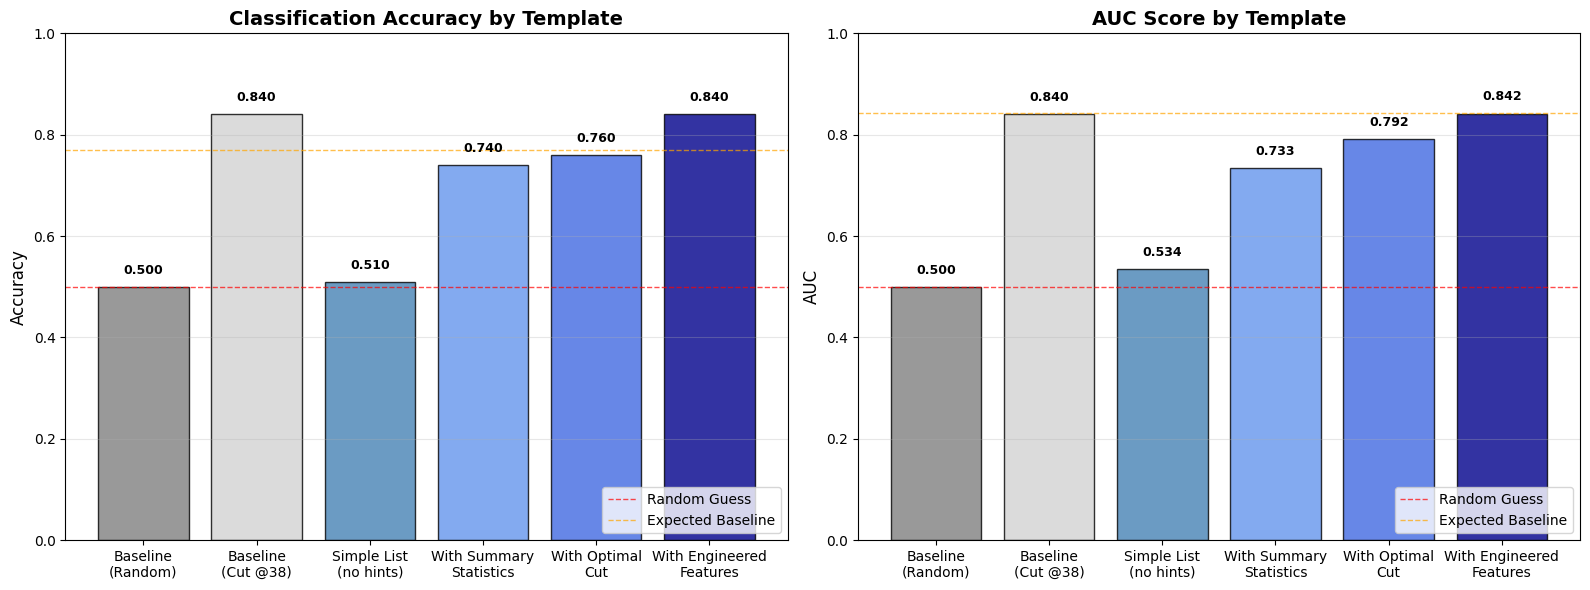


TEMPLATE COMPARISON SUMMARY
Template                       Accuracy     AUC          vs Baseline    
--------------------------------------------------------------------------------
Baseline (Random)              0.5000       0.5000       -0.3400
Baseline (Cut @38)             0.8400       0.8400       +0.0000
Simple List (no hints)         0.5100       0.5343       -0.3300
With Summary Statistics        0.7400       0.7333       -0.1000
With Optimal Cut               0.7600       0.7917       -0.0800
With Engineered Features       0.8400       0.8417       +0.0000

Key Findings:
  • Baseline (simple cut): 0.8400 accuracy
  • Best performing template: With Engineered
Features
  • Improvement from basic to informed: 0.3073
  • All informed templates beat random baseline


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect results
results = {
    'Baseline\n(Random)': {'acc': 0.50, 'auc': 0.50},
    'Baseline\n(Cut @38)': {'acc': acc_baseline, 'auc': acc_baseline},
    'Simple List\n(no hints)': {'acc': acc, 'auc': auc},
    'With Summary\nStatistics': {'acc': acc_stats, 'auc': auc_stats},
    'With Optimal\nCut': {'acc': acc_cut, 'auc': auc_cut},
    'With Engineered\nFeatures': {'acc': acc_features, 'auc': auc_features},
}

# Create bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

templates = list(results.keys())
accuracies = [results[t]['acc'] for t in templates]
aucs = [results[t]['auc'] for t in templates]

# Colors: baseline gray, original blue, informed templates gradient
colors = ['gray', 'lightgray', 'steelblue', 'cornflowerblue', 'royalblue', 'darkblue']

# Accuracy plot
bars1 = axes[0].bar(range(len(templates)), accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0].axhline(y=0.50, color='red', linestyle='--', linewidth=1, label='Random Guess', alpha=0.7)
axes[0].axhline(y=0.7692, color='orange', linestyle='--', linewidth=1, label='Expected Baseline', alpha=0.7)
axes[0].set_xticks(range(len(templates)))
axes[0].set_xticklabels(templates, rotation=0, ha='center', fontsize=10)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Classification Accuracy by Template', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(loc='lower right')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, accuracies)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# AUC plot
bars2 = axes[1].bar(range(len(templates)), aucs, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(y=0.50, color='red', linestyle='--', linewidth=1, label='Random Guess', alpha=0.7)
axes[1].axhline(y=0.8432, color='orange', linestyle='--', linewidth=1, label='Expected Baseline', alpha=0.7)
axes[1].set_xticks(range(len(templates)))
axes[1].set_xticklabels(templates, rotation=0, ha='center', fontsize=10)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('AUC Score by Template', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(loc='lower right')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, aucs)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("TEMPLATE COMPARISON SUMMARY")
print("="*80)
print(f"{'Template':<30} {'Accuracy':<12} {'AUC':<12} {'vs Baseline':<15}")
print("-"*80)
for name, res in results.items():
    name_clean = name.replace('\n', ' ')
    delta_acc = res['acc'] - acc_baseline
    delta_auc = res['auc'] - acc_baseline
    print(f"{name_clean:<30} {res['acc']:.4f}       {res['auc']:.4f}       {delta_acc:+.4f}")
print("="*80)

print(f"\nKey Findings:")
print(f"  • Baseline (simple cut): {acc_baseline:.4f} accuracy")
print(f"  • Best performing template: {max(results.keys(), key=lambda k: results[k]['auc'])}")
print(f"  • Improvement from basic to informed: {max(aucs) - aucs[2]:.4f}")
print(f"  • All informed templates beat random baseline")


### Cost Analysis

Compare token usage and costs across all templates.


TOKEN USAGE AND COST SUMMARY
Template                  Prompt     Completion   Thinking   Total      Cost ($)  
------------------------------------------------------------------------------------------
Simple List (no hints)    164,253    2,669        93,278     260,200    $0.0411   
With Summary Statistics   90,757     385          27,376     118,518    $0.0151   
With Optimal Cut          93,107     50           8,337      101,494    $0.0095   
With Engineered Features  104,507    50           41,081     145,638    $0.0202   
------------------------------------------------------------------------------------------
TOTAL                     452,624    3,154        170,072    625,850    $0.0859   

📊 Token Distribution:
  Prompt tokens:      452,624 ( 72.3%)
  Completion tokens:    3,154 (  0.5%)
  Thinking tokens:    170,072 ( 27.2%)
  Total tokens:       625,850

💰 Cost Analysis:
  Total cost: $0.0859
  Cost per jet: $0.001718
  Cost per 1000 jets: $1.72


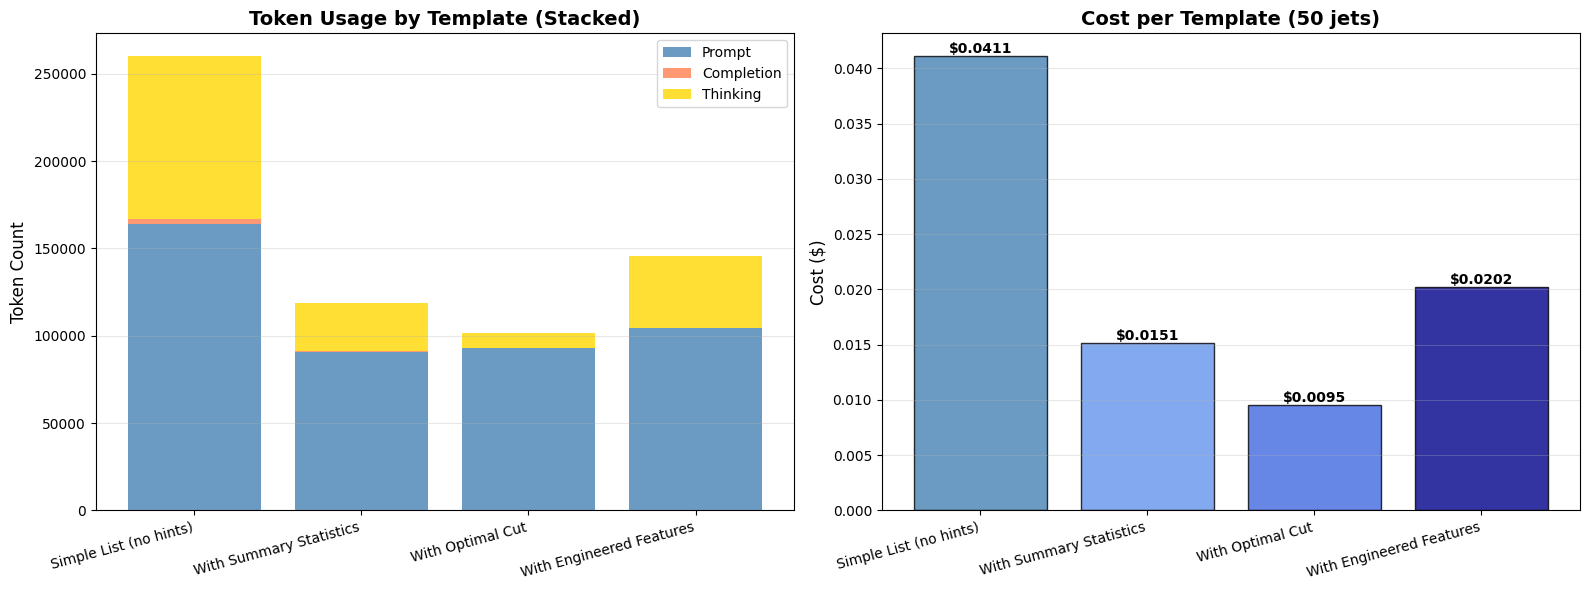


💡 Cost Insights:
  • Longer prompts (engineered features) use more prompt tokens
  • Thinking tokens are consistent across templates (~same thinking budget)
  • Most expensive: Simple List (no hints) ($0.0411)
  • Most economical: With Optimal Cut ($0.0095)


In [18]:
# Collect cost data from all classifiers
cost_data = {
    'Simple List\n(no hints)': {
        'prompt': clf.total_prompt_tokens,
        'completion': clf.total_completion_tokens,
        'thinking': clf.total_thinking_tokens,
        'cost': clf.total_cost
    },
    'With Summary\nStatistics': {
        'prompt': clf_stats.total_prompt_tokens,
        'completion': clf_stats.total_completion_tokens,
        'thinking': clf_stats.total_thinking_tokens,
        'cost': clf_stats.total_cost
    },
    'With Optimal\nCut': {
        'prompt': clf_cut.total_prompt_tokens,
        'completion': clf_cut.total_completion_tokens,
        'thinking': clf_cut.total_thinking_tokens,
        'cost': clf_cut.total_cost
    },
    'With Engineered\nFeatures': {
        'prompt': clf_features.total_prompt_tokens,
        'completion': clf_features.total_completion_tokens,
        'thinking': clf_features.total_thinking_tokens,
        'cost': clf_features.total_cost
    }
}

# Print cost summary table
print("="*90)
print("TOKEN USAGE AND COST SUMMARY")
print("="*90)
print(f"{'Template':<25} {'Prompt':<10} {'Completion':<12} {'Thinking':<10} {'Total':<10} {'Cost ($)':<10}")
print("-"*90)

total_prompt = 0
total_completion = 0
total_thinking = 0
total_cost = 0

for name, data in cost_data.items():
    name_clean = name.replace('\n', ' ')
    total_tokens = data['prompt'] + data['completion'] + data['thinking']
    print(f"{name_clean:<25} {data['prompt']:<10,} {data['completion']:<12,} {data['thinking']:<10,} "
          f"{total_tokens:<10,} ${data['cost']:<9.4f}")
    
    total_prompt += data['prompt']
    total_completion += data['completion']
    total_thinking += data['thinking']
    total_cost += data['cost']

print("-"*90)
total_all_tokens = total_prompt + total_completion + total_thinking
print(f"{'TOTAL':<25} {total_prompt:<10,} {total_completion:<12,} {total_thinking:<10,} "
      f"{total_all_tokens:<10,} ${total_cost:<9.4f}")
print("="*90)

# Cost breakdown by token type
print(f"\n📊 Token Distribution:")
print(f"  Prompt tokens:     {total_prompt:>8,} ({total_prompt/total_all_tokens*100:>5.1f}%)")
print(f"  Completion tokens: {total_completion:>8,} ({total_completion/total_all_tokens*100:>5.1f}%)")
print(f"  Thinking tokens:   {total_thinking:>8,} ({total_thinking/total_all_tokens*100:>5.1f}%)")
print(f"  Total tokens:      {total_all_tokens:>8,}")

print(f"\n💰 Cost Analysis:")
print(f"  Total cost: ${total_cost:.4f}")
print(f"  Cost per jet: ${total_cost/n_test:.6f}")
print(f"  Cost per 1000 jets: ${total_cost/n_test*1000:.2f}")

# Visualize costs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Token usage stacked bar chart
templates_cost = [name.replace('\n', ' ') for name in cost_data.keys()]
prompt_tokens = [cost_data[name]['prompt'] for name in cost_data.keys()]
completion_tokens = [cost_data[name]['completion'] for name in cost_data.keys()]
thinking_tokens = [cost_data[name]['thinking'] for name in cost_data.keys()]

x = range(len(templates_cost))
axes[0].bar(x, prompt_tokens, label='Prompt', color='steelblue', alpha=0.8)
axes[0].bar(x, completion_tokens, bottom=prompt_tokens, label='Completion', color='coral', alpha=0.8)
axes[0].bar(x, thinking_tokens, 
           bottom=[p+c for p,c in zip(prompt_tokens, completion_tokens)],
           label='Thinking', color='gold', alpha=0.8)

axes[0].set_xticks(x)
axes[0].set_xticklabels(templates_cost, rotation=15, ha='right')
axes[0].set_ylabel('Token Count', fontsize=12)
axes[0].set_title('Token Usage by Template (Stacked)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Cost comparison
costs = [cost_data[name]['cost'] for name in cost_data.keys()]
bars = axes[1].bar(x, costs, color=['steelblue', 'cornflowerblue', 'royalblue', 'darkblue'], 
                   alpha=0.8, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(templates_cost, rotation=15, ha='right')
axes[1].set_ylabel('Cost ($)', fontsize=12)
axes[1].set_title(f'Cost per Template ({n_test} jets)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'${cost:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Cost Insights:")
print(f"  • Longer prompts (engineered features) use more prompt tokens")
print(f"  • Thinking tokens are consistent across templates (~same thinking budget)")
print(f"  • Most expensive: {templates_cost[costs.index(max(costs))]} (${max(costs):.4f})")
print(f"  • Most economical: {templates_cost[costs.index(min(costs))]} (${min(costs):.4f})")


## Reasoning Budget Comparison

Test how doubling the thinking budget (1000 → 2000 tokens) affects performance.
Run all templates on 100 jets with both thinking budgets.


In [19]:
# Test configuration
n_test_extended = 100
X_sample_extended = X_test[:n_test_extended]
y_sample_extended = y_test[:n_test_extended]

# Template configurations
template_configs = [
    ("simple_list", "Simple List"),
    ("with_summary_stats", "With Summary Stats"),
    ("with_optimal_cut", "With Optimal Cut"),
    ("with_engineered_features", "With Engineered Features")
]

# Thinking budgets to test
thinking_budgets = [1000, 2000]

# Store results
all_results = {}

print("="*80)
print("RUNNING EXTENDED REASONING BUDGET COMPARISON")
print("="*80)
print(f"Testing {len(template_configs)} templates × {len(thinking_budgets)} budgets × {n_test_extended} jets")
print(f"Total API calls: {len(template_configs) * len(thinking_budgets) * n_test_extended}")
print("="*80)

for template_name, template_label in template_configs:
    for budget in thinking_budgets:
        key = f"{template_label} (budget={budget})"
        
        print(f"\n{'='*70}")
        print(f"Testing: {template_label} with thinking_budget={budget}")
        print(f"{'='*70}")
        
        # Create classifier
        clf_test = LLMClassifier(
            model_name="gemini-2.5-flash-lite-preview-09-2025",
            template_name=template_name,
            format_type="list",
            thinking_budget=budget,
            max_tokens=3000,  # Enough for thinking + completion
            templates_dir="../templates"
        )
        
        clf_test.fit([], [])
        
        # Run predictions
        print(f"Processing {n_test_extended} jets...")
        predictions = clf_test.predict(X_sample_extended)
        
        # Calculate metrics
        acc = accuracy_score(y_sample_extended, predictions)
        auc = roc_auc_score(y_sample_extended, predictions)
        
        # Store results
        all_results[key] = {
            'template': template_label,
            'budget': budget,
            'accuracy': acc,
            'auc': auc,
            'prompt_tokens': clf_test.total_prompt_tokens,
            'completion_tokens': clf_test.total_completion_tokens,
            'thinking_tokens': clf_test.total_thinking_tokens,
            'cost': clf_test.total_cost,
            'predictions': predictions
        }
        
        print(f"\nResults:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  AUC:      {auc:.4f}")
        print(f"  Thinking tokens: {clf_test.total_thinking_tokens:,}")
        print(f"  Total cost: ${clf_test.total_cost:.4f}")

print("\n" + "="*80)
print("TESTING COMPLETE")
print("="*80)


RUNNING EXTENDED REASONING BUDGET COMPARISON
Testing 4 templates × 2 budgets × 100 jets
Total API calls: 800

Testing: Simple List with thinking_budget=1000
Processing 100 jets...


100%|██████████| 100/100 [04:52<00:00,  2.93s/it]



Results:
  Accuracy: 0.5200
  AUC:      0.5495
  Thinking tokens: 90,622
  Total cost: $0.0403

Testing: Simple List with thinking_budget=2000
Processing 100 jets...


100%|██████████| 100/100 [09:23<00:00,  5.63s/it]



Results:
  Accuracy: 0.4900
  AUC:      0.5162
  Thinking tokens: 199,469
  Total cost: $0.0733

Testing: With Summary Stats with thinking_budget=1000
Processing 100 jets...


 56%|█████▌    | 56/100 [01:34<01:23,  1.91s/it]

100%|██████████| 100/100 [02:43<00:00,  1.63s/it]



Results:
  Accuracy: 0.6900
  AUC:      0.6859
  Thinking tokens: 65,936
  Total cost: $0.0336

Testing: With Summary Stats with thinking_budget=2000
Processing 100 jets...


100%|██████████| 100/100 [06:10<00:00,  3.71s/it]



Results:
  Accuracy: 0.8200
  AUC:      0.8222
  Thinking tokens: 167,654
  Total cost: $0.0641

Testing: With Optimal Cut with thinking_budget=1000
Processing 100 jets...


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]



Results:
  Accuracy: 0.7300
  AUC:      0.7525
  Thinking tokens: 18,528
  Total cost: $0.0197

Testing: With Optimal Cut with thinking_budget=2000
Processing 100 jets...


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]



Results:
  Accuracy: 0.8600
  AUC:      0.8707
  Thinking tokens: 23,139
  Total cost: $0.0211

Testing: With Engineered Features with thinking_budget=1000
Processing 100 jets...


 63%|██████▎   | 63/100 [02:05<00:48,  1.32s/it]

Error calling Gemini API: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Error calling Gemini API: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}


100%|██████████| 100/100 [03:14<00:00,  1.95s/it]



Results:
  Accuracy: 0.7100
  AUC:      0.7000
  Thinking tokens: 78,186
  Total cost: $0.0407

Testing: With Engineered Features with thinking_budget=2000
Processing 100 jets...


100%|██████████| 100/100 [06:30<00:00,  3.90s/it]


Results:
  Accuracy: 0.7800
  AUC:      0.7778
  Thinking tokens: 190,728
  Total cost: $0.0732

TESTING COMPLETE


### Comprehensive Comparison Visualizations

Compare all templates across both thinking budgets.


/tmp/ipykernel_1141448/2557091453.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


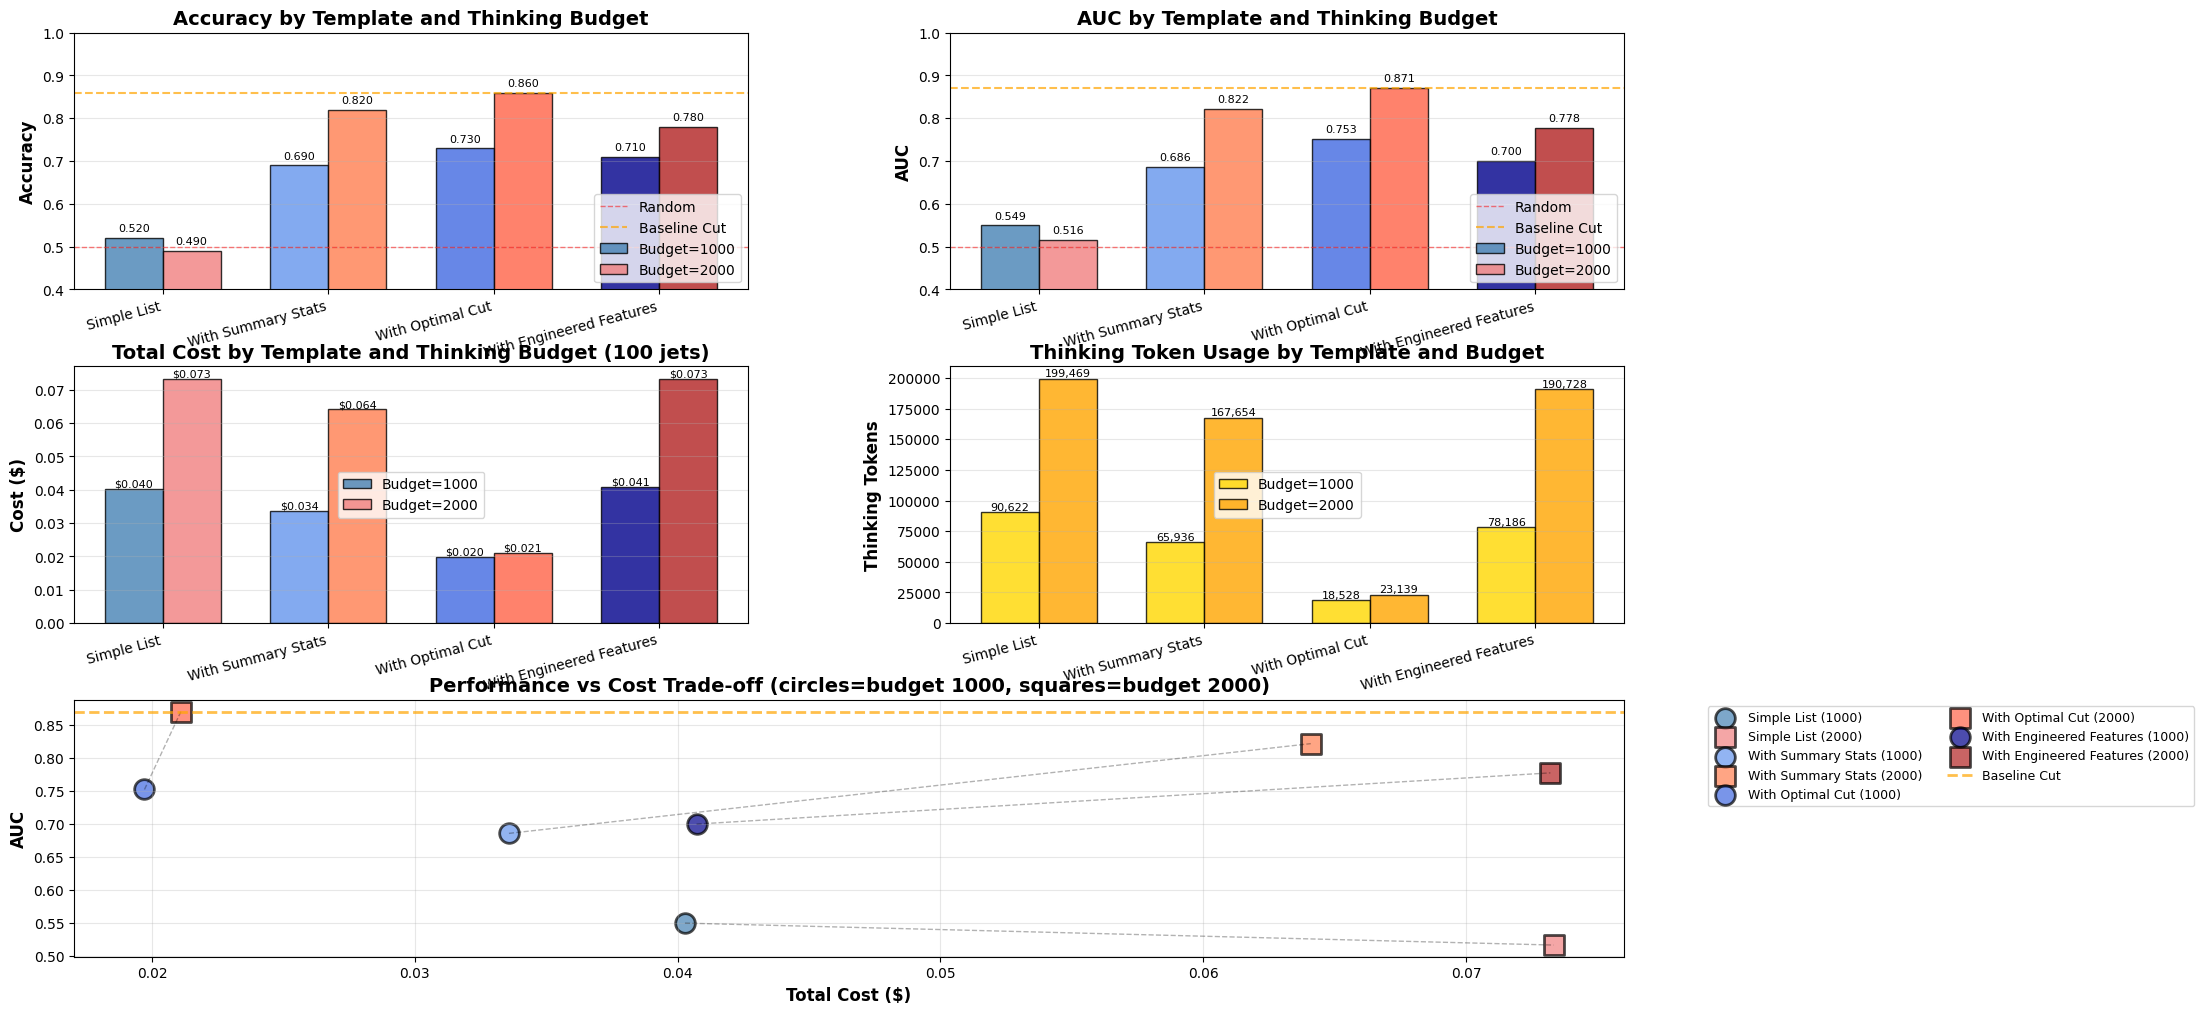

In [20]:
# Create comprehensive comparison plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Prepare data
templates = ["Simple List", "With Summary Stats", "With Optimal Cut", "With Engineered Features"]
colors_1000 = ['steelblue', 'cornflowerblue', 'royalblue', 'darkblue']
colors_2000 = ['lightcoral', 'coral', 'tomato', 'firebrick']

# Calculate baseline for reference
mult_sample_extended = np.sum(X_sample_extended[:, :, 0] > 0, axis=1)
pred_baseline_extended = (mult_sample_extended <= 38).astype(int)
acc_baseline_extended = accuracy_score(y_sample_extended, pred_baseline_extended)
auc_baseline_extended = roc_auc_score(y_sample_extended, pred_baseline_extended)

# 1. Accuracy Comparison (Grouped Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(templates))
width = 0.35

acc_1000 = [all_results[f"{t} (budget=1000)"]['accuracy'] for t in templates]
acc_2000 = [all_results[f"{t} (budget=2000)"]['accuracy'] for t in templates]

bars1 = ax1.bar(x - width/2, acc_1000, width, label='Budget=1000', color=colors_1000, alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, acc_2000, width, label='Budget=2000', color=colors_2000, alpha=0.8, edgecolor='black')

ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random')
ax1.axhline(y=acc_baseline_extended, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline Cut')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy by Template and Thinking Budget', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(templates, rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.4, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. AUC Comparison (Grouped Bar Chart)
ax2 = fig.add_subplot(gs[0, 1])
auc_1000 = [all_results[f"{t} (budget=1000)"]['auc'] for t in templates]
auc_2000 = [all_results[f"{t} (budget=2000)"]['auc'] for t in templates]

bars3 = ax2.bar(x - width/2, auc_1000, width, label='Budget=1000', color=colors_1000, alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, auc_2000, width, label='Budget=2000', color=colors_2000, alpha=0.8, edgecolor='black')

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random')
ax2.axhline(y=auc_baseline_extended, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline Cut')
ax2.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax2.set_title('AUC by Template and Thinking Budget', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(templates, rotation=15, ha='right')
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.4, 1.0])

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Cost Comparison
ax3 = fig.add_subplot(gs[1, 0])
cost_1000 = [all_results[f"{t} (budget=1000)"]['cost'] for t in templates]
cost_2000 = [all_results[f"{t} (budget=2000)"]['cost'] for t in templates]

bars5 = ax3.bar(x - width/2, cost_1000, width, label='Budget=1000', color=colors_1000, alpha=0.8, edgecolor='black')
bars6 = ax3.bar(x + width/2, cost_2000, width, label='Budget=2000', color=colors_2000, alpha=0.8, edgecolor='black')

ax3.set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
ax3.set_title(f'Total Cost by Template and Thinking Budget ({n_test_extended} jets)', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(templates, rotation=15, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.3f}', ha='center', va='bottom', fontsize=8)

# 4. Token Usage Comparison (Stacked)
ax4 = fig.add_subplot(gs[1, 1])
thinking_1000 = [all_results[f"{t} (budget=1000)"]['thinking_tokens'] for t in templates]
thinking_2000 = [all_results[f"{t} (budget=2000)"]['thinking_tokens'] for t in templates]

bars7 = ax4.bar(x - width/2, thinking_1000, width, label='Budget=1000', color='gold', alpha=0.8, edgecolor='black')
bars8 = ax4.bar(x + width/2, thinking_2000, width, label='Budget=2000', color='orange', alpha=0.8, edgecolor='black')

ax4.set_ylabel('Thinking Tokens', fontsize=12, fontweight='bold')
ax4.set_title('Thinking Token Usage by Template and Budget', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(templates, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars7, bars8]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=8)

# 5. Performance vs Cost Scatter Plot
ax5 = fig.add_subplot(gs[2, :])
for i, template in enumerate(templates):
    key_1000 = f"{template} (budget=1000)"
    key_2000 = f"{template} (budget=2000)"
    
    # Plot both budgets
    ax5.scatter(all_results[key_1000]['cost'], all_results[key_1000]['auc'], 
               s=200, marker='o', color=colors_1000[i], alpha=0.7, edgecolor='black', linewidth=2,
               label=f"{template} (1000)")
    ax5.scatter(all_results[key_2000]['cost'], all_results[key_2000]['auc'], 
               s=200, marker='s', color=colors_2000[i], alpha=0.7, edgecolor='black', linewidth=2,
               label=f"{template} (2000)")
    
    # Connect with line
    ax5.plot([all_results[key_1000]['cost'], all_results[key_2000]['cost']],
            [all_results[key_1000]['auc'], all_results[key_2000]['auc']],
            'k--', alpha=0.3, linewidth=1)

ax5.axhline(y=auc_baseline_extended, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Baseline Cut')
ax5.set_xlabel('Total Cost ($)', fontsize=12, fontweight='bold')
ax5.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax5.set_title('Performance vs Cost Trade-off (circles=budget 1000, squares=budget 2000)', 
             fontsize=14, fontweight='bold')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=9)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Summary Tables


In [21]:
# Print comprehensive summary table
print("="*120)
print(f"COMPREHENSIVE RESULTS: ALL TEMPLATES × ALL THINKING BUDGETS ({n_test_extended} jets)")
print("="*120)
print(f"{'Template':<30} {'Budget':<10} {'Accuracy':<10} {'AUC':<10} {'Cost ($)':<12} {'Thinking Tokens':<15}")
print("-"*120)

# Sort by template then budget
sorted_keys = sorted(all_results.keys(), key=lambda k: (all_results[k]['template'], all_results[k]['budget']))

for key in sorted_keys:
    res = all_results[key]
    print(f"{res['template']:<30} {res['budget']:<10} {res['accuracy']:<10.4f} {res['auc']:<10.4f} "
          f"${res['cost']:<11.4f} {res['thinking_tokens']:<15,}")

print("-"*120)

# Calculate totals
total_cost_all = sum(res['cost'] for res in all_results.values())
total_thinking_all = sum(res['thinking_tokens'] for res in all_results.values())
total_calls = len(all_results) * n_test_extended

print(f"{'TOTALS':<30} {'':<10} {'':<10} {'':<10} ${total_cost_all:<11.4f} {total_thinking_all:<15,}")
print("="*120)

# Key insights
print(f"\n📊 Key Insights:")
print(f"\n1. BASELINE COMPARISON:")
print(f"   Baseline (cut @38): Accuracy={acc_baseline_extended:.4f}, AUC={auc_baseline_extended:.4f}")
print(f"   Best LLM result:    {max(all_results.keys(), key=lambda k: all_results[k]['auc'])}")
print(f"   Best AUC:           {max(res['auc'] for res in all_results.values()):.4f}")

print(f"\n2. THINKING BUDGET IMPACT:")
for template in templates:
    key_1000 = f"{template} (budget=1000)"
    key_2000 = f"{template} (budget=2000)"
    delta_auc = all_results[key_2000]['auc'] - all_results[key_1000]['auc']
    delta_cost = all_results[key_2000]['cost'] - all_results[key_1000]['cost']
    print(f"   {template:<30} ΔAUC={delta_auc:+.4f}, ΔCost=${delta_cost:+.4f}")

print(f"\n3. TEMPLATE EFFECTIVENESS:")
avg_by_template = {}
for template in templates:
    avg_auc = np.mean([all_results[f"{template} (budget={b})"]['auc'] for b in thinking_budgets])
    avg_by_template[template] = avg_auc
    print(f"   {template:<30} Avg AUC={avg_auc:.4f}")

best_template = max(avg_by_template, key=avg_by_template.get)
print(f"\n   Best overall template: {best_template}")

print(f"\n4. COST ANALYSIS:")
print(f"   Total cost for all experiments: ${total_cost_all:.4f}")
print(f"   Total API calls: {total_calls:,}")
print(f"   Average cost per jet: ${total_cost_all/total_calls:.6f}")
print(f"   Projected cost for 10,000 jets (best config): ${(total_cost_all/total_calls)*10000:.2f}")

print(f"\n5. REASONING VALUE:")
avg_auc_1000 = np.mean([all_results[f"{t} (budget=1000)"]['auc'] for t in templates])
avg_auc_2000 = np.mean([all_results[f"{t} (budget=2000)"]['auc'] for t in templates])
avg_cost_1000 = np.mean([all_results[f"{t} (budget=1000)"]['cost'] for t in templates])
avg_cost_2000 = np.mean([all_results[f"{t} (budget=2000)"]['cost'] for t in templates])

print(f"   Budget=1000: Avg AUC={avg_auc_1000:.4f}, Avg Cost=${avg_cost_1000:.4f}")
print(f"   Budget=2000: Avg AUC={avg_auc_2000:.4f}, Avg Cost=${avg_cost_2000:.4f}")
print(f"   Doubling budget: ΔAUC={avg_auc_2000-avg_auc_1000:+.4f}, ΔCost=${avg_cost_2000-avg_cost_1000:+.4f}")
print(f"   {'Worth it!' if (avg_auc_2000-avg_auc_1000) > 0.01 else 'Marginal benefit'}")


COMPREHENSIVE RESULTS: ALL TEMPLATES × ALL THINKING BUDGETS (100 jets)
Template                       Budget     Accuracy   AUC        Cost ($)     Thinking Tokens
------------------------------------------------------------------------------------------------------------------------
Simple List                    1000       0.5200     0.5495     $0.0403      90,622         
Simple List                    2000       0.4900     0.5162     $0.0733      199,469        
With Engineered Features       1000       0.7100     0.7000     $0.0407      78,186         
With Engineered Features       2000       0.7800     0.7778     $0.0732      190,728        
With Optimal Cut               1000       0.7300     0.7525     $0.0197      18,528         
With Optimal Cut               2000       0.8600     0.8707     $0.0211      23,139         
With Summary Stats             1000       0.6900     0.6859     $0.0336      65,936         
With Summary Stats             2000       0.8200     0.8222     